Dataset shape: (1599, 12)

Feature statistics:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
m

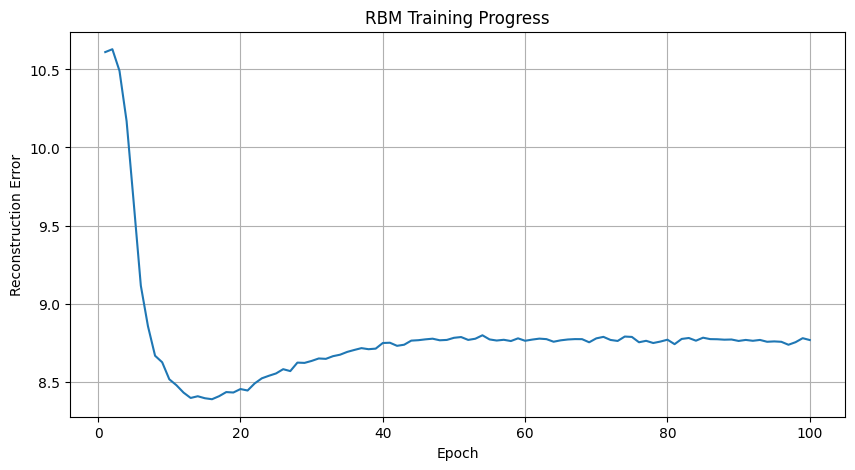

Extracting features using trained RBM...
Training Random Forest classifier...

Classification Accuracy: 0.8625

Classification Report:
              precision    recall  f1-score   support

        High       0.72      0.49      0.58        43
         Low       0.00      0.00      0.00        13
      Medium       0.88      0.97      0.92       264

    accuracy                           0.86       320
   macro avg       0.53      0.48      0.50       320
weighted avg       0.82      0.86      0.84       320



<Figure size 800x600 with 0 Axes>

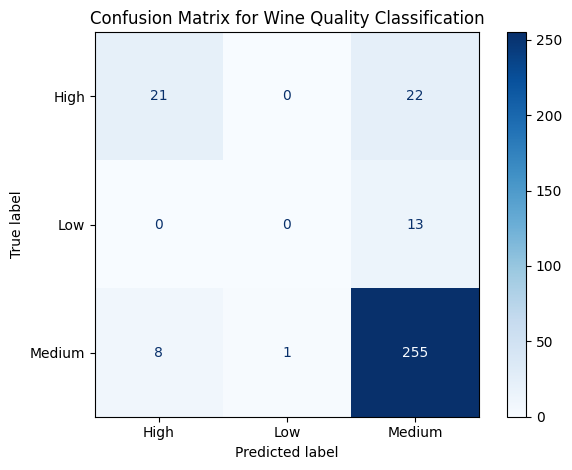

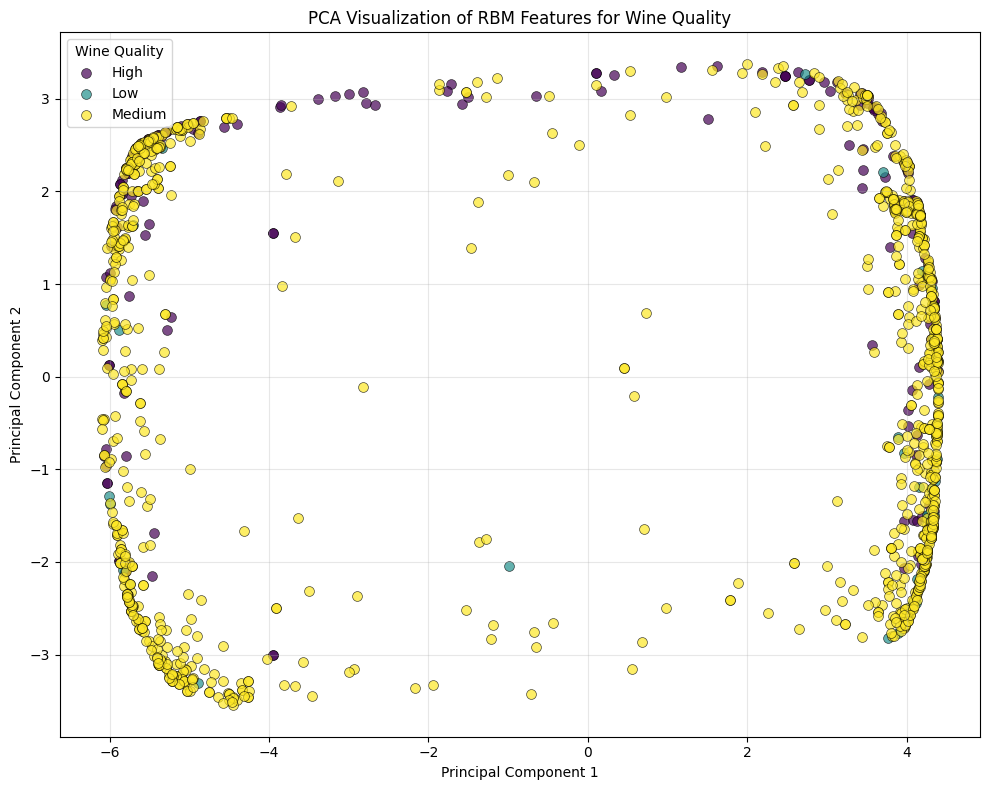

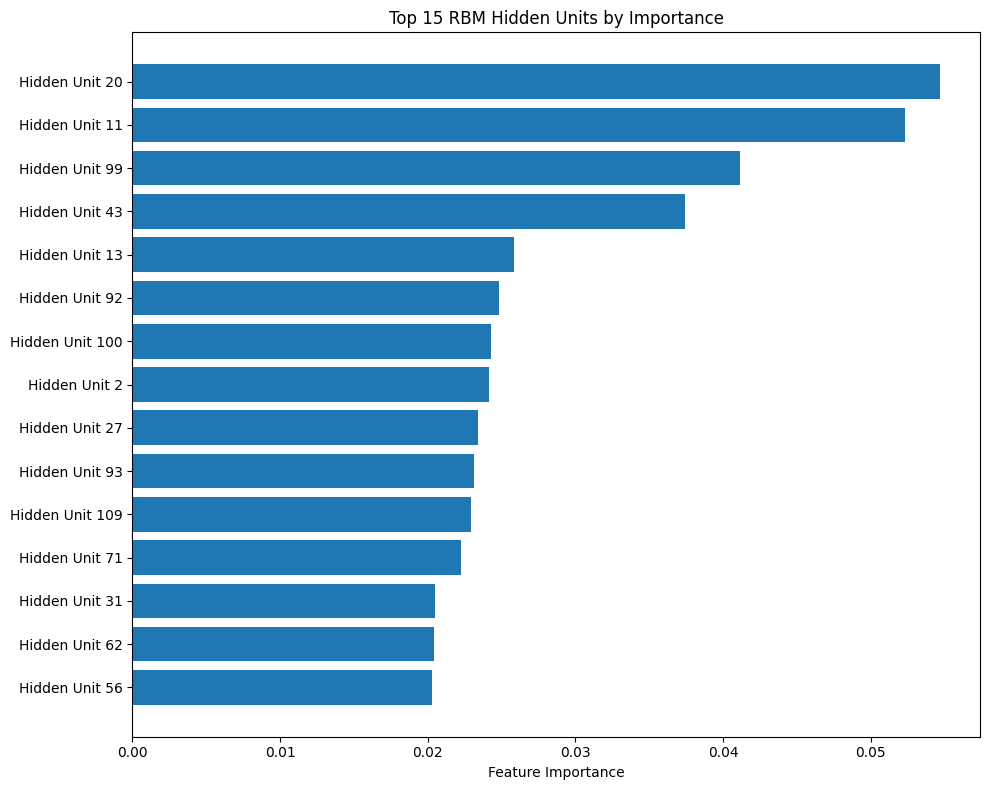

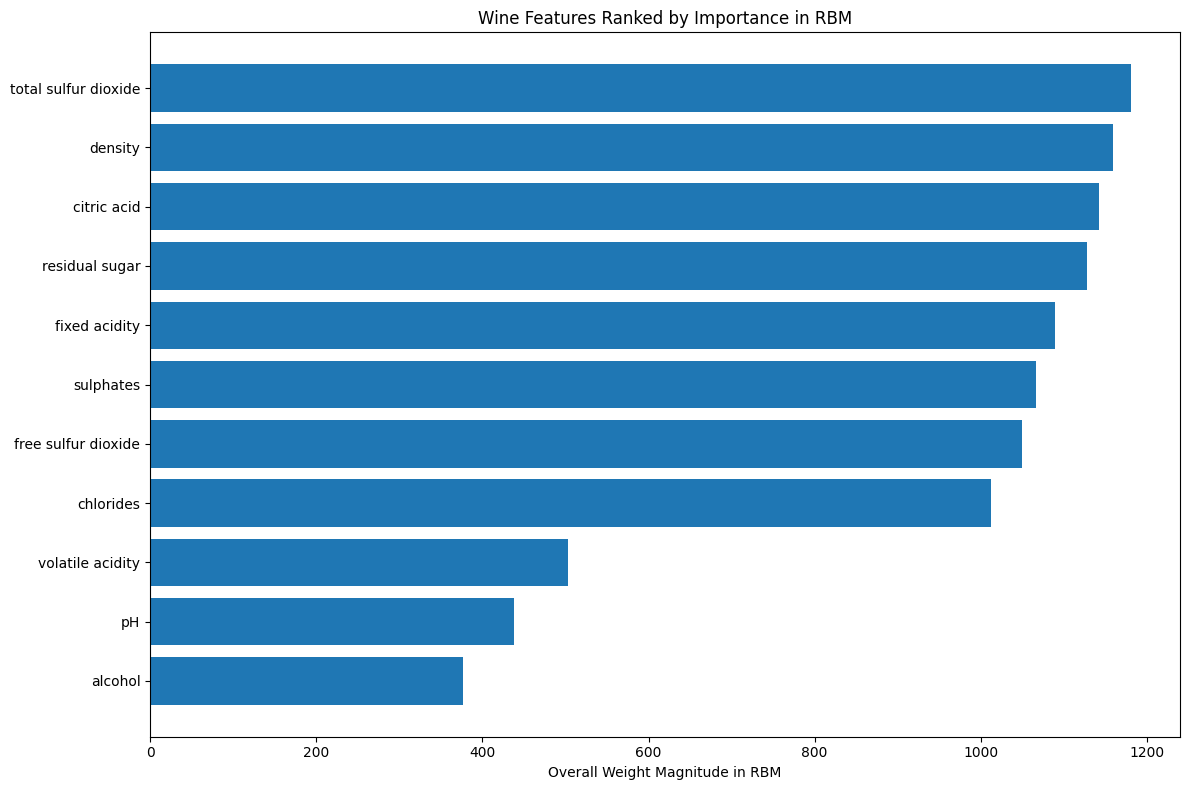


Analysis complete! All results and visualizations have been saved and displayed.


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')

# Exploratory data analysis
print("Dataset shape:", df.shape)
print("\nFeature statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:", df.isnull().sum().sum())

# Preprocess dataset
X = df.drop(columns=['quality'])  # Features
y = df['quality']  # Labels

# Check class distribution
print("\nClass distribution:")
print(y.value_counts().sort_index())

# Handle class imbalance - consolidate rare classes
# Convert the original 6-class problem to a 3-class problem
def remap_quality(quality):
    if quality <= 4:
        return 'Low'
    elif quality <= 6:
        return 'Medium'
    else:
        return 'High'

y_grouped = y.apply(remap_quality)
print("\nGrouped class distribution:")
print(y_grouped.value_counts())

# Use the grouped classes for better classification
y = y_grouped

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Convert to torch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)

# Define RBM class
class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(hidden_units, visible_units) * 0.1)
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))
        self.v_bias = nn.Parameter(torch.zeros(visible_units))

    def sample_h(self, v):
        h_prob = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        h_sample = torch.bernoulli(h_prob)
        return h_prob, h_sample

    def sample_v(self, h):
        v_prob = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        v_sample = torch.bernoulli(v_prob)
        return v_prob, v_sample

    def free_energy(self, v):
        vbias_term = torch.matmul(v, self.v_bias)
        wx_b = torch.matmul(v, self.W.t()) + self.h_bias
        hidden_term = torch.sum(torch.log(1 + torch.exp(wx_b)), dim=1)
        return -hidden_term - vbias_term

    def forward(self, v):
        h_prob, _ = self.sample_h(v)
        return h_prob

    def reconstruction_error(self, v):
        h_prob, h_sample = self.sample_h(v)
        v_prob, v_sample = self.sample_v(h_sample)
        return torch.mean(torch.sum((v - v_prob)**2, dim=1))

# Train RBM
visible_units = X_train.shape[1]
hidden_units = 128  # Increased for better feature extraction
batch_size = 64     # Increased for more stable training
num_epochs = 100    # More epochs for better convergence
learning_rate = 0.005  # Slightly reduced learning rate
k = 15  # More Gibbs sampling steps

rbm = RBM(visible_units, hidden_units)
optimizer = optim.Adam(rbm.parameters(), lr=learning_rate)

# Training loop
training_losses = []

print("\nTraining RBM model...")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    # Shuffle data at each epoch
    indices = torch.randperm(X_train_tensor.size(0))
    X_train_tensor_shuffled = X_train_tensor[indices]

    # Mini-batch training
    for i in range(0, X_train_tensor.size(0), batch_size):
        batch = X_train_tensor_shuffled[i:i+batch_size]
        if batch.size(0) < 2:  # Skip too small batches
            continue

        # Positive phase
        pos_hidden_prob, pos_hidden_sample = rbm.sample_h(batch)

        # Initialize the chain with the current batch
        v_k = batch.clone()

        # Perform k steps of Gibbs sampling
        for _ in range(k):
            h_k_prob, h_k_sample = rbm.sample_h(v_k)
            v_k_prob, v_k_sample = rbm.sample_v(h_k_sample)
            v_k = v_k_sample

        # Negative phase
        neg_hidden_prob, _ = rbm.sample_h(v_k)

        # Compute gradients manually
        optimizer.zero_grad()

        # Compute weight gradients
        pos_associations = torch.matmul(pos_hidden_prob.t(), batch)
        neg_associations = torch.matmul(neg_hidden_prob.t(), v_k)

        # Update gradients
        rbm.W.grad = -(pos_associations - neg_associations) / batch.size(0)
        rbm.v_bias.grad = -torch.mean(batch - v_k, dim=0)
        rbm.h_bias.grad = -torch.mean(pos_hidden_prob - neg_hidden_prob, dim=0)

        # Update parameters
        optimizer.step()

        # Calculate reconstruction error for monitoring
        recon_error = rbm.reconstruction_error(batch)
        epoch_loss += recon_error.item()
        num_batches += 1

    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / max(1, num_batches)  # Prevent division by zero
    training_losses.append(avg_epoch_loss)

    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Reconstruction Error: {avg_epoch_loss:.4f}")

# Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_losses)
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.title('RBM Training Progress')
plt.grid(True)
plt.savefig('rbm_training_curve.png')
plt.show()

# Extract features from RBM
print("Extracting features using trained RBM...")
with torch.no_grad():
    X_train_features = rbm.forward(X_train_tensor).numpy()
    X_test_features = rbm.forward(X_test_tensor).numpy()

# Train classifier
print("Training Random Forest classifier...")
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
clf.fit(X_train_features, y_train)

# Get class labels
class_labels = clf.classes_

# Evaluate classifier
y_pred = clf.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nClassification Accuracy: {accuracy:.4f}")

# Print classification report with zero_division parameter
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Wine Quality Classification")
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Perform PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_features)

# Scatter plot for clustering
plt.figure(figsize=(10, 8))
# Use the safer pyplot colormap approach that won't raise deprecation warnings
classes = np.unique(y_train)
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))

for i, c in enumerate(classes):
    plt.scatter(X_pca[y_train == c, 0], X_pca[y_train == c, 1],
                c=[colors[i]], label=c, alpha=0.7, s=50, edgecolors='k', linewidths=0.5)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of RBM Features for Wine Quality")
plt.legend(title="Wine Quality")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('pca_visualization.png')
plt.show()

# Feature importance analysis - based on hidden unit importance
importances = clf.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features

plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [f'Hidden Unit {i}' for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 15 RBM Hidden Units by Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Original feature importance through RBM weights
# Calculate the overall importance of input features based on RBM weights
with torch.no_grad():
    feature_importance = torch.sum(torch.abs(rbm.W), dim=0).numpy()

original_features = df.columns[:-1]
feature_indices = np.argsort(feature_importance)

plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_indices)), feature_importance[feature_indices])
plt.yticks(range(len(feature_indices)), [original_features[i] for i in feature_indices])
plt.xlabel('Overall Weight Magnitude in RBM')
plt.title('Wine Features Ranked by Importance in RBM')
plt.tight_layout()
plt.savefig('original_feature_importance.png')
plt.show()

print("\nAnalysis complete! All results and visualizations have been saved and displayed.")